In [1]:
import pandas as pd

# Prepare each letter and corresponding info to load into dataframe
years = []
letters = []
wcs = []
with open('letters.txt', 'r', encoding='utf8') as file:
    for count, line in enumerate(file):
        years.append(count+1977)
        letters.append(line)

        # Find word count without numbers and punctuation
        word_count = 0
        words = line.split()
        for word in words: 
            if word.isalpha(): word_count += 1
        wcs.append(word_count)

# Load letters into dataframe
df = pd.DataFrame()
df['Year'] = years
df['Letter'] = letters
df['Word Count'] = wcs
df.head()

,Year,Letter,Word Count
0,1977,To the Stockholders of Berkshire Hathaway Inc....,2842
1,1978,To the Shareholders of Berkshire Hathaway Inc....,3978
2,1979,To the Shareholders of Berkshire Hathaway Inc....,6282
3,1980,To the Shareholders of Berkshire Hathaway Inc....,7007
4,1981,To the Shareholders of Berkshire Hathaway Inc....,6151


In [72]:
import nltk
import re

# Define list of stopwords and stemmer
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

# Process letters to get a list of words and a list of sentences
proc_words = []
proc_sents = []
for i, letter in enumerate(letters):

    # Split letter into list of words
    words = letter.split()
    words = [word for word in words if word.isalpha()]  # Remove punctuation and numbers
    words = [word.lower() for word in words if word.lower() not in stopwords]  # Remove stopwords
    stem_words = []
    for word in words:  # Create list of stemmed words
        if stemmer.stem(word) in stem_words: continue
        else: stem_words.append(stemmer.stem(word))
    proc_words.append(stem_words)

    # Split letter into list of sentences and remove figures
    sents = nltk.sent_tokenize(letter)
    for sent in sents:
        if (re.search("\.\.\.\.\.", sent)) is not None:  # Figures indicated by long elipses
            del sents[sents.index(sent)]
        if (re.search("\. \. \. \. ", sent)) is not None:  # 21st letter has spaces inbetween periods
            del sents[sents.index(sent)]
    proc_sents.append(sents)

# Load list of words into dataframe for ease of access
df_words = pd.DataFrame()
df_words['Year'] = years
df_words['Letter'] = proc_words
df_words['Word Count'] = [len(letter) for letter in proc_words]

# Load list of sentences into dataframe
df_sents = pd.DataFrame()
df_sents['Year'] = years
df_sents['Letter'] = proc_sents
df_sents['Sentence Count'] = [len(letter) for letter in proc_sents]
df_sents.head()

,Year,Letter,Sentence Count
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,128
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,162
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,251
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,310
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,281


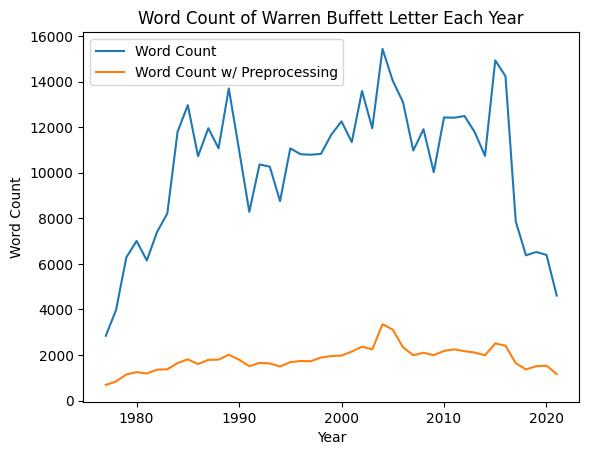

In [75]:
import matplotlib.pyplot as plt

# Plot hist of word counts
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(df['Year'], df['Word Count'], label='Word Count')
ax.plot(df_words['Year'], df_words['Word Count'], label='Word Count w/ Preprocessing')
ax.set_title('Word Count of Warren Buffett Letter Each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Word Count')
ax.legend()

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

# Combine all lists of words into one list and create a count vector
letters = []
for letter in df_words['Letter']:
    letter = ' '.join(letter)
    letters.append(letter)

# Use sklearn for count vectorization
cv = CountVectorizer()
words_vector = cv.fit_transform(letters)
tokens = cv.get_feature_names()
words_vector

/home/ben/.pyenv/versions/3.10.6/envs/CS565/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<45x14634 sparse matrix of type '<class 'numpy.int64'>'
	with 81662 stored elements in Compressed Sparse Row format>